# Chapter 13 - Parallelizing NN training with TensorFlow

TensorFlow is one of the most popular deep learning libraries and can be used to implement NN's much more efficiently than any of the previous NumPy implementations. TF can significantly speed up ML tasks

TensorFlow is developed to utilize GPU's; GPU's have many more cores and can thus do much more floating-point calculations per second. However, writing code to target GPU's is not as easy as simply writing Python code. TensorFlow can help in these cases.


## What is TensorFlow?

Tensorflow is a scalable and multiplatform programming interface for implementing and running ML-algorithms, including convenience wrappers for deep learning. It supports multiple programming languages, but the Python API is currently the most complete.

Tensorflow is built around a computation graph composed of a set of nodes. Each node represents an operation. Tensors are the values'scaler is a rank-0 tensor, a vector is a rank-1 tensor, a matrix a rank-2 tensor etc.

In [2]:
import tensorflow as tf

##create a graph
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype = tf.float32,
                      shape = (None), name = 'x')
    w = tf.Variable(2.0, name = 'weight')
    b = tf.Variable(0.7, name = 'bias')
    z = tf.add((w*x), b)
    
    init = tf.global_variables_initializer()
    
#Create a session and pass in graph g
with tf.Session(graph = g) as sess:
    #initialize w and b
    sess.run(init)
    for t in [1.0, 0.6, -1.8]:
        print('x = %4.1f --> z = %4.1f' %(t, sess.run(z, feed_dict={x:t})))

x =  1.0 --> z =  2.7
x =  0.6 --> z =  1.9
x = -1.8 --> z = -2.9


In [4]:
with tf.Session(graph = g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x:[1.,2.,3.]}))

[2.7 4.7 6.7]


In [5]:
#Working with array structures --> Create a simple rank-3 tensor of batchsizex2x3, reshape it and calculate colsums
import tensorflow as tf
import numpy as np

g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype = tf.float32,
                      shape = (None, 2, 3),
                      name = 'input_x')
    x2 = tf.reshape(x, shape = (-1, 6),
                   name = 'x2')
    
    #Calculate sum of each column
    xsum = tf.reduce_sum(x2, axis = 0, name = 'col_sum')
    
    #Calculate mean of each column
    xmean = tf.reduce_mean(x2, axis = 0, name = 'col_mean')
    
with tf.Session(graph = g) as sess:
    x_array = np.arange(18).reshape(3,2,3)
    
    print('input shape: ', x_array.shape)
    print('Reshaped:\n',
         sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums:\n',
         sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means:\n',
         sess.run(xmean, feed_dict={x:x_array}))

input shape:  (3, 2, 3)
Reshaped:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


## Developing a simple model with the low-level TensorFlow API

Implemenation of ordinary least squares (OLS) regression.

In [6]:
import tensorflow as tf
import numpy as np

X_train = np.arange(10).reshape((10,1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

### Implement the model in a class.
Steps
* 1) we need two placeholders -> one for X and one for y.
* 2) Next we need to define the trainable variables - weights w and bias b
* 3) Then define linear regression model as z = wx+b
* 4) Define cost function to be MSE
* 5) learn weight parameters by gradient descent optimizer


In [21]:
class TFLinreg(object):
    def __init__(self, x_dim, learning_rate = 0.01, random_seed = None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        ## Build the model
        with self.g.as_default():
            ##set graph-level random-seed
            tf.set_random_seed(random_seed)
            
            self.build()
            ##Create initializer
            self.init_op = tf.global_variables_initializer()
    
    def build(self):
        ## define placeholders for inputs
        self.X = tf.placeholder(dtype = tf.float32,
                              shape = (None, self.x_dim),
                              name = 'x_input')
        self.y = tf.placeholder(dtype = tf.float32,
                               shape = (None),
                               name = 'y_input')
        
        print(self.X)
        print(self.y)
        #define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape = (1)),
                       name = 'weight')
        b = tf.Variable(tf.zeros(shape = (1)),
                       name = 'bias')
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w*self.X + b,
                               name = 'z_net')
        print(self.z_net)
        
        sqr_errors = tf.square(self.y-self.z_net,
                              name = 'sqr_errors')
        print(sqr_errors)
        
        self.mean_cost = tf.reduce_mean(sqr_errors,
                                       name = 'mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = self.learning_rate,
                                                     name = 'GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [22]:
lrmodel = TFLinreg(x_dim = X_train.shape[1], learning_rate = 0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)
Instructions for updating:
Use tf.cast instead.


In [29]:
#For training we implment a seperate function that needs a TensorFlow session, a model instance, 
#training data and the number of epochs as input arguments

#Then we iterate and call the optimizer operation of the model while feeding the training data.
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## initialize all variables: W and b
    sess.run(model.init_op)
    
    training_costs=[]
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                          feed_dict = {model.X:X_train,
                                      model.y:y_train})
        
        training_costs.append(cost)
    return training_costs

In [30]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

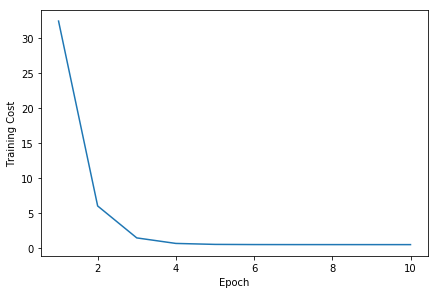

In [32]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

In [33]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net,
                     feed_dict={model.X:X_test})
    return y_pred

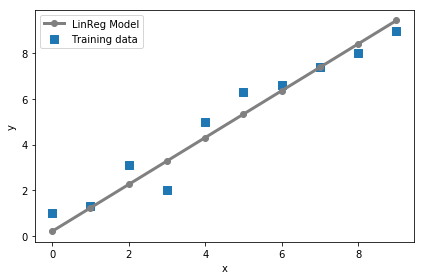

In [35]:
plt.scatter(X_train, y_train, marker = 's', s= 50, label = 'Training data')
plt.plot(range(X_train.shape[0]),
        predict_linreg(sess, lrmodel, X_train),
        color = 'gray', marker = 'o',
        markersize = 6, linewidth = 3,
        label = 'LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

## Training NN's efficiently with high-level TensorFlow APIs

For example Keras, which supports Theano and TensorFlow.

First we will build a NN via the Layers API.

In [36]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [37]:
X_train, y_train = load_mnist('./MNIST', kind = "train")
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('./MNIST', kind = "t10k")
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

#mean centering and normalization
mean_vals = np.mean(X_train, axis = 0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_test

print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

Rows: 60000, columns: 784
Rows: 10000, columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [40]:
import tensorflow as tf

n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype = tf.float32,
                         shape = (None, n_features),
                         name = 'tf_x')
    tf_y = tf.placeholder(dtype = tf.int32,
                         shape = None, name = 'tf_y')
    
    y_onehot = tf.one_hot(indices=tf_y, depth = n_classes)
    
    h1 = tf.layers.dense(inputs = tf_x, units = 50,
                        activation = tf.tanh,
                        name = 'layer1')
    h2 = tf.layers.dense(inputs = h1, units = 50,
                        activation = tf.tanh,
                        name = 'layer2')
    
    logits = tf.layers.dense(inputs = h2, units = 10,
                        activation = None,
                        name = 'layer3')
    
    predictions = {
        'classes' : tf.argmax(logits, axis = 1,
                             name = 'predicted_classes'),
        'probabilities' : tf.nn.softmax(logits,
                                       name = 'softmax_tensor')
    }

In [45]:
#Define cost function and optimizer
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(
            onehot_labels = y_onehot, logits = logits)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    
    train_op = optimizer.minimize(loss = cost)
    
    init_op = tf.global_variables_initializer()

In [46]:
#Method to generate barches of data
def create_batch_generator(X, y, batch_size = 128, shuffle = False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
        
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])

In [47]:
#Now we can create a TF session initialize all the variables and train it 
# (and display the avaerage training loss after each epoch.)

#Create a session to launch the grahp
sess = tf.Session(graph = g)
##run the variable initializer
sess.run(init_op)

##50 epochs of training
for epoch in range(50):
    training_costs = []
    batch_generator = create_batch_generator(X_train_centered, y_train, batch_size = 64)
    for batch_X, batch_y in batch_generator:
        ##preperate a dict to feed ddata to our network:
        feed = {tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict = feed)
        training_costs.append(batch_cost)
        
    print(' -- Epoch %2d  Avg. Training loss: %.4f' % (epoch+1, np.mean(training_costs)))

 -- Epoch  1  Avg. Training loss: 1.5573
 -- Epoch  2  Avg. Training loss: 0.9492
 -- Epoch  3  Avg. Training loss: 0.7499
 -- Epoch  4  Avg. Training loss: 0.6387
 -- Epoch  5  Avg. Training loss: 0.5668
 -- Epoch  6  Avg. Training loss: 0.5160
 -- Epoch  7  Avg. Training loss: 0.4781
 -- Epoch  8  Avg. Training loss: 0.4486
 -- Epoch  9  Avg. Training loss: 0.4247
 -- Epoch 10  Avg. Training loss: 0.4051
 -- Epoch 11  Avg. Training loss: 0.3884
 -- Epoch 12  Avg. Training loss: 0.3741
 -- Epoch 13  Avg. Training loss: 0.3617
 -- Epoch 14  Avg. Training loss: 0.3507
 -- Epoch 15  Avg. Training loss: 0.3408
 -- Epoch 16  Avg. Training loss: 0.3320
 -- Epoch 17  Avg. Training loss: 0.3239
 -- Epoch 18  Avg. Training loss: 0.3165
 -- Epoch 19  Avg. Training loss: 0.3097
 -- Epoch 20  Avg. Training loss: 0.3035
 -- Epoch 21  Avg. Training loss: 0.2976
 -- Epoch 22  Avg. Training loss: 0.2921
 -- Epoch 23  Avg. Training loss: 0.2870
 -- Epoch 24  Avg. Training loss: 0.2822
 -- Epoch 25  Av

In [49]:
#Do prediction on test set:
feed = {tf_x: X_test_centered}
y_pred = sess.run(predictions['classes'],
                 feed_dict = feed)
print('Test Accuracy: %.2f%%' % (100*np.sum(y_pred == y_test)/y_test.shape[0]))

Test Accuracy: 93.89%


## Developing a multilayer NN with Keras

In [50]:
X_train, y_train = load_mnist('./MNIST', kind = "train")
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('./MNIST', kind = "t10k")
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

#mean centering and normalization
mean_vals = np.mean(X_train, axis = 0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_test

print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

Rows: 60000, columns: 784
Rows: 10000, columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [52]:
import tensorflow as tf
import tensorflow.keras as keras

np.random.seed(123)
tf.set_random_seed(123)

y_train_onehot = keras.utils.to_categorical(y_train)
print('First 3 labels: ', y_train[:3])
print('\nFirst 3 labels (one-hot):\n', y_train_onehot[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [53]:
#Keras with three layers (first two have 50 hidden units) and tanh as activation function
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 50,
        input_dim=X_train_centered.shape[1],
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'))

model.add(
    keras.layers.Dense(
        units = 50,
        input_dim=50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'))

model.add(
    keras.layers.Dense(
        units = y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'softmax'))

sgd_optimizer = keras.optimizers.SGD(lr = 0.001, decay = 1e-7, momentum = .9)

model.compile(optimizer = sgd_optimizer, loss = 'categorical_crossentropy')

In [54]:
history = model.fit(X_train_centered, y_train_onehot,
                   batch_size = 64, epochs = 50,
                   verbose = 1, validation_split = 0.1) #Use verbose=1 to follow the optimization of the cost function

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 4s 76us/sample - loss: 0.7422 - val_loss: 0.3736
Epoch 2/50
54000/54000 [==============================] - 2s 41us/sample - loss: 0.3781 - val_loss: 0.2805
Epoch 3/50
54000/54000 [==============================] - 2s 41us/sample - loss: 0.3109 - val_loss: 0.2411
Epoch 4/50
54000/54000 [==============================] - 2s 39us/sample - loss: 0.2737 - val_loss: 0.2171
Epoch 5/50
54000/54000 [==============================] - 2s 40us/sample - loss: 0.2478 - val_loss: 0.1999
Epoch 6/50
54000/54000 [==============================] - 2s 38us/sample - loss: 0.2276 - val_loss: 0.1842
Epoch 7/50
54000/54000 [==============================] - 2s 40us/sample - loss: 0.2110 - val_loss: 0.1732
Epoch 8/50
54000/54000 [==============================] - 2s 39us/sample - loss: 0.1973 - val_loss: 0.1640
Epoch 9/50
54000/54000 [==============================] - 2s 40us/sample - loss: 0.1854 - val_l

In [56]:
#we can use the predict_classes method to return the classl labels directly as integers.
y_train_pred = model.predict_classes(X_train_centered, verbose = 1)
print('First 3 predictions: ', y_train_pred[:3])

60000/60000 [==============================] - 1s 23us/sample
First 3 predictions:  [5 0 4]


In [57]:
#print model accuracy on training and test sets
y_train_pred = model.predict_classes(X_train_centered, verbose = 0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)
train_acc = correct_preds / y_train.shape[0]

print('First 3 predictions: ', y_train_pred[:3])
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test_centered, verbose = 0)
correct_preds = np.sum(y_test == y_test_pred, axis = 0)
test_acc = correct_preds / y_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))


First 3 predictions:  [5 0 4]
Training accuracy: 98.81%
Test accuracy: 96.27%


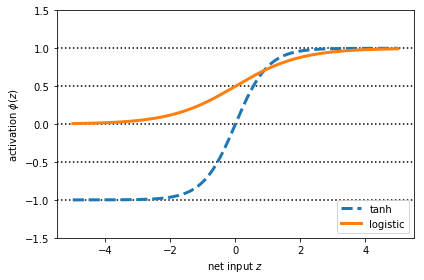

In [60]:
## Choosing activation functions for multilayer networks.
# Tanh has a wider range of possible values [-1,1] compared to sigmoid [0,1]; can sometims improve convergence
import matplotlib.pyplot as plt

def tanh(z): #also available als np.tanh()
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

def logistic(z): #also available als expit() from scipy.special
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-5,5,0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5,1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color = 'black', linestyle = ':')
plt.axhline(0.5, color = 'black', linestyle = ':')
plt.axhline(0, color = 'black', linestyle = ':')
plt.axhline(-0.5, color = 'black', linestyle = ':')
plt.axhline(-1, color = 'black', linestyle = ':')
plt.plot(z, tanh_act,
        linewidth = 3, linestyle = '--', label = 'tanh')
plt.plot(z, log_act,
        linewidth = 3, label = 'logistic')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()